# Coursework 1 - Synfire chains

The aim of this coursework is to reproduce and extend the results of the following paper:

[Diesmann et al (1999) "Stable propagation of synchronous spiking in cortical neural networks"](https://www.nature.com/articles/990101) ([pdf](http://www.honda-ri.de/pubs/pdf/1406.pdf))

You can extend the code developed in the exercises in weeks 1 and 2.

You will need to read the paper, paying particular attention to the Methods section, to understand what the model is. As is often the case in older scientific papers, no code is provided and not all the details needed are given. You will need to think and experiment a bit to fill in the gaps.

You should submit your results as a Jupyter notebook that can be run on Google Colab. You should describe your code and results. Your code should be clear, and well commented, and your text should be clearly written and easy to follow. Remember, it will be assessed by 3 or more randomly selected individuals from the class. They will download and run your code, and if it does not work or they cannot understand it, you will get fewer marks.

A more detailed, step-by-step guide follows.

In [250]:
# These imports should be enough to do everything in this coursework, but feel free to use others
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import poisson

## Task 1: implement a simulator for the model in the paper

Your simulator should have the following features:

1. Leaky integrate-and-fire neuron with alpha synapse acting on the current (note: not on the membrane potential). You should have two time constants, membrane time constant and alpha synapse time constant.
2. Background noise as a Poisson process (see notes below).
3. Refractoriness (see notes below).
4. Initialisation with an input spike burst as described in the paper.
5. All-to-all connectivity between layers. That is, each neuron in layer $i$ is connected to each neuron in layer $j$ (with the same weight).
6. Delay between layers (so a spike in layer $i$ takes a fixed amount of time before arriving in layer $i+1$).

You can build your simulator iteratively adding features as you verify the properties and reproduce the plots below. For task 2A, you only need feature (1). For task 2B you need features (1-3). For task 3 onwards you need all 6 features.

Recommended approach: try to solve task 2A first using only a simulator with feature (1). Now add features (2-3) and solve task 2B. Once you've finished that, go back and check your code still works for taks 2A. Continue like this.

### Poisson background noise

You can implement Poisson background noise by computing the mean number of expected noise spikes in any time step (product of sum of input firing rates and time step size), and then at each time step drawing a random, Poisson distributed value with this mean. You can the ``poisson`` function imported above to do this. Note that in this case there are two populations of neurons, one excitatory and one inhibitory.

### Refractoriness

After a spike, the neuron shuts down (membrane potential stays at reset value and incoming spikes are ignored) for a period of time called the refractory period. You can implement this by tracking, for each neuron, the last time it spiked, and only adding spikes for neurons which haven't fired within the refractory period.

### Suggested implementation

* A function that simulates a single layer of the network, taking the output spikes of the previous layer as an input argument, and returning its own output spikes.
* A function that generates spikes for an input burst in the same format as the input/output of the simulate layer function above.

In [258]:
# Use this template and fill in the gaps where there is a ...

def simulate_layer(num_neurons=None, num_time_steps=None, spikes_in=None, noise=True, delay=5):
    if spikes_in is None and (num_neurons is None or num_time_steps is None):
        raise ValueError("You need to specify either spikes_in or num_neurons and num_time_steps")
    if spikes_in is not None:
        num_neurons, num_time_steps = spikes_in.shape
        
    ### Parameters
    dt = 0.1
    resting_potential = -70.0
    potential_threshold = -55.0
    tau_alpha = 0.4
    tau_membrane = 10.0
    refactory_period = 1.0
    membrane_resistance = 4.05

    if spikes_in is None:
        spikes_in = np.zeros((num_neurons, num_time_steps))
    else:
        spikes_in = np.roll(spikes_in,delay/dt) 
        spikes_in[:,:int(delay/dt)] = 0

    ### Setup the simulation
    v = np.full(num_neurons,fill_value=-70.0) #potential 
    x = np.zeros(num_neurons) #synapse intermediate
    y = np.zeros(num_neurons) #current
    t_last = np.full(num_neurons, fill_value=-1e9 ) #last spike timestamp
    # ...
    # record activity
    v_rec = np.zeros((num_neurons, num_time_steps))
    spikes_out = np.zeros((num_neurons, num_time_steps))
    # apply input delay
    # ...
    # generate background noise
  
    excitatory_count, inhibitory_count = 17600, 2400        
    excitatory_rate, inhibitory_rate = 2.0, 12.5
    if noise:
        lambda_excitatory = excitatory_rate * excitatory_count * (dt/1000)  
        lambda_inhibitory = inhibitory_rate * inhibitory_count * (dt/1000) 
        v_mean_noise = 8.25
        v_std_dev = 2.85
        v += np.random.normal(v_mean_noise, v_std_dev)
        v = np.random.uniform(low=resting_potential, high=potential_threshold, size=num_neurons)
        for t_idx in range(num_time_steps):
            noise_excitatory = np.random.poisson(lambda_excitatory, num_neurons)
            noise_inhibitory = np.random.poisson(lambda_inhibitory, num_neurons)
            spikes_in[:, t_idx] += noise_excitatory - noise_inhibitory
            
            

    ### Run simulation
    for t_idx in range(num_time_steps):
        t = t_idx*dt
        refactored_neurons = (t - t_last) < refactory_period
        non_refactored_neurons = ~refactored_neurons
        x_prime = -x / tau_alpha
        y_prime = (x-y) / tau_alpha
        x += x_prime*dt + spikes_in[:, t_idx]
        y += y_prime*dt
        v_prime = (membrane_resistance * y + resting_potential - v) / tau_membrane
        v[non_refactored_neurons] += v_prime[non_refactored_neurons]*dt
        v[refactored_neurons] = resting_potential
        spiked_neurons = v >= potential_threshold
        v[spiked_neurons] = resting_potential
        v_rec[:, t_idx] = v 
        spikes_out[:, t_idx] = spiked_neurons
        t_last[spiked_neurons] = t
        
    print(spikes_out)
    return v_rec+70, spikes_out


def input_burst(num_neurons=100, num_active=50, offset=0, sigma=0, num_time_steps=700, dt=0.1):
    
    spikes = np.zeros((num_neurons, num_time_steps))
    chosen_neurons = np.random.choice(num_neurons,num_active,replace=False)
    for neuron in chosen_neurons:
        spike_time = np.random.normal(offset,sigma)
        spike_step = int(spike_time/dt)
        if 0 <= spike_step < num_time_steps:
            spikes[neuron,spike_step]=1
    
    return spikes


# How might you use this function?
def all_to_all(spikes, n_out=None):
    s = spikes.sum(axis=0)[None, :]
    if n_out is None:
        n_out = spikes.shape[0]
    return np.repeat(s, n_out, axis=0)

## Task 2: validate neuron, synapse and network properties

### Task 2A: validate postsynaptic potential

Write down the differential equations for your model.

Verify that you have implemented the neuron and synapse model correctly by feeding it a single input spike, plotting the membrane potential (postsynaptic potential, PSP) and checking that the time to peak, and peak value are as given in the paper. It doesn't have to be absolutely perfect, just close enough.

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
Alpha PSP verification
  Maximum of PSP is 0.1400 and should be 0.14
  Maximum is attained at time 1.70 and should be 1.7



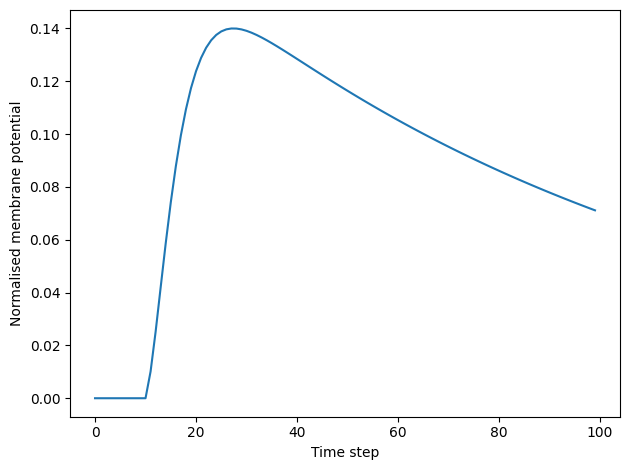

In [252]:
# Use this template and fill in the ...
# Verify synapse properties with no background noise and single input spike
s_in = np.zeros((1, 100)) # duration 10ms
s_in[0, 10] = 1 # single input spike at time t=1ms
v, s = simulate_layer(spikes_in=s_in, noise=False, delay=0)
plt.figure()
plt.plot(v[0, :])
plt.xlabel('Time step')
plt.ylabel('Normalised membrane potential')
plt.tight_layout()
print('Alpha PSP verification')
print(f'  Maximum of PSP is {v.max():.4f} and should be 0.14') # what is the correct value for ...?
print(f'  Maximum is attained at time {(v.argmax()-10)*0.1:.2f} and should be 1.7') # what is the correct value for ...?
print()

Expected results:

![Expected results](result_2a.png)

### Task 2B: validate background noise

Verify that in the absence of any input spikes, neurons in the network fire noise spikes at approximately the rate given in the paper, and that the mean and standard deviation of the membrane potential is as given in the paper. Plot the output spikes and 5 membrane potentials to check that the results seem sensible.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Background firing rate verification
  Mean rate is 2.8 Hz, should be ...
  Membrane potential mean is 7.79, should be 8.25
  Membrane potential std is 2.95, should be 2.85


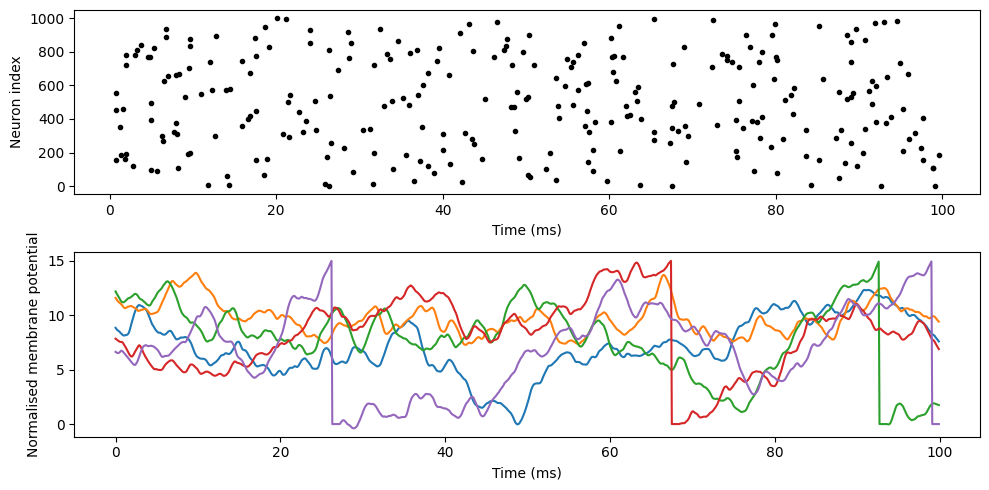

In [259]:
# Verify background noise gives appropriate level of output noise
v, s = simulate_layer(num_neurons=1000, num_time_steps=1000)
i, t = s.nonzero()
t = t*0.1 # dt
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.plot(t, i, '.k')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.subplot(212)
plt.plot(np.arange(1000)*0.1, v[:5, :1000].T)
plt.xlabel('Time (ms)')
plt.ylabel('Normalised membrane potential')
plt.tight_layout()
print('Background firing rate verification')
# TODO: Fill in the ... values below
print(f'  Mean rate is {s.sum()/(1000*1000*0.1*1e-3):.1f} Hz, should be ...') # ...
print(f'  Membrane potential mean is {v.mean():.2f}, should be 8.25') # ...
print(f'  Membrane potential std is {v.std():.2f}, should be 2.85') # ...

Expected results:

![Expected results](results_2b.png)

## Task 3: reproduce figures 1d and 1e from the paper

The plotting doesn't have to be perfect, but it should be recognisably similar to the paper.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

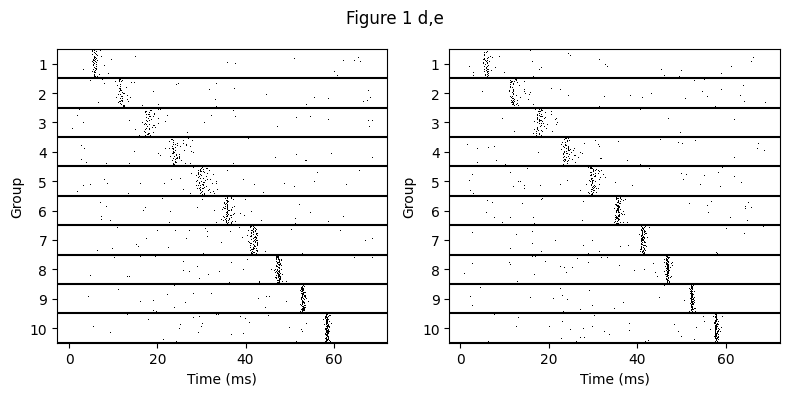

In [260]:
# Verify figure 1d,e
# TODO: Fill in missing value
num_neurons = 100
plt.figure(figsize=(8, 4))
# TODO: Fill in missing value
a_values = [50,48]
for plotidx, a in enumerate(a_values):
    s = input_burst(num_neurons=num_neurons, num_active=a)
    plt.subplot(1, 2, plotidx+1)
    for layer in range(10):
        # TODO: Add something here to represent the effect of the all-to-all spike connection
        #       Or incorporate into the simulate_layer function
        s_accumulated = all_to_all(s)
        _, s = simulate_layer(spikes_in=s_accumulated)
        i, t = s.nonzero()
        plt.plot(t*0.1, i/100+9-layer, ',k')
        plt.axhline(layer, c='k')
    plt.ylim(0, 10)
    plt.yticks(np.arange(10)+0.5, np.arange(1, 11)[::-1])
    plt.xlabel('Time (ms)')
    plt.ylabel('Group')
plt.suptitle('Figure 1 d,e')
plt.tight_layout();

Expected results (may not be exactly the same each time you run):

![Expected results](result_3.png)

## Task 4: reproduce figures 2c and 2d

In this case, the paper is lacking a lot of detail in how to estimate the probability and spread of an output spike. You are unlikely to be able to perfectly reproduce the output, but you should be able to get something similar and justify your results, or explain why you think the paper got it wrong if you disagree.

In [255]:
# TODO: Fill in all the ... below
# Your implementation of estimate_pulse_parameters might need additional arguments depending how you implement it

# Verify figure 2c,d
def estimate_pulse_parameters(s): # you can change the arguments to this function if you need
    # Now we want to estimate the number of spikes caused and their spread.
    # alpha = probability of an output spike = number of output spikes / number of neurons
    # sigma_out = spread (in ms) of output spikes caused by the pulse
    return alpha, sigma_out

def neural_transmission(a_in, sigma_in, repeats=1000, dt=0.1):
    # We put in a burst of a_in spikes with spread sigma_in
    s = input_burst(num_neurons=a_in, num_active=a_in, sigma=sigma_in, ...)
    # Run the simulation for one layer
    _, s = simulate_layer(...)
    return estimate_pulse_parameters(s)

plt.figure(figsize=(8, 4))
plt.subplot(121)
for sigma in [0, 1, 3, 5]:
    A_IN = np.arange(0, 150+1, 10)
    ALPHA = [neural_transmission(a_in, sigma)[0] for a_in in A_IN]
    plt.plot(A_IN, ALPHA, label=f'$\\sigma_{{in}}={sigma}$ ms')
plt.xlabel(r'$a_{in}$ (spikes)')
plt.ylabel(r'$\alpha$')
plt.legend(loc='best')
plt.subplot(122)
for a_in in [45, 65, 105, 145]:
    SIGMA_IN = np.linspace(0, 5, 15)
    SIGMA_OUT = [neural_transmission(a_in, sigma_in)[1] for sigma_in in SIGMA_IN]
    plt.plot(SIGMA_IN, SIGMA_OUT, label=f'$a_{{in}}={a_in}$ ms')
plt.plot([0, 5], [0, 5], ls='--', c='grey', zorder=-1)
plt.xlabel(r'$\sigma_{in}$ (ms)')
plt.ylabel(r'$\sigma_{out}$ (ms)')
plt.legend(loc='best')
plt.suptitle('Figure 2 c, d')
plt.tight_layout();

SyntaxError: positional argument follows keyword argument (542529775.py, line 13)

Expected results (as you can see, not exactly the same as in the paper which I couldn't reproduce perfectly):

![Expected results](result_4.png)

## Task 5: reproduce figure 3c

It is sufficient to plot some of the trajectories, and not the separatrix (dashed line).

In [ ]:
# TODO: Replace the ... below
# Validation figure 3c
starting_points = [
    ...
    ]
repeats = ...
layersize = ...
for idx, (a, sigma) in enumerate(starting_points):
    A, SIGMA = [a], [sigma]
    for _ in range(10):
        # ... code that updates values of a, sigma
        A.append(a)
        SIGMA.append(sigma)
    plt.plot(SIGMA, A, c=f'C{idx}')
    for i in range(len(SIGMA)-1):
        plt.annotate('', (SIGMA[i+1], A[i+1]), xytext=(SIGMA[i], A[i]), arrowprops=dict(arrowstyle='->', shrinkA=0, shrinkB=0, color=f'C{idx}'))
plt.xlim(0, 3)
plt.ylim(0, 100)
plt.xlabel(r'$\sigma$ (ms)')
plt.ylabel('$a$ (spikes)')
plt.title('Figure 3c')
plt.tight_layout();

Expected results:

![Expected results](result_5.png)

## Task 6 (optional extra credit)

It is possible to obtain a first class grade from the parts above. This part is for extra credit.

Investigate some aspect of the model that you think is interesting and is not covered in the paper. Explain why you think it's interesting and present your results coherently.

Some ideas (but feel free to use your own):
* Do the results depend on the choice of model parameters given in the paper? How precisely?
* Do the results depend on the choice of synapse model in the paper?
* Do the results depend on all-to-all connectivity between layers?